In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio
import cmocean as cm
import seaborn as sns  


In [2]:
project = 'kolmogorov'

In [3]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 20

In [5]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [6]:
u1 = np.load(f'{project_root}/data/{project}/u1.npy') 
u2 = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')
nt, n1, n2 = u1.shape

X, scaler = transform_data_for_AE(u1,u2)
X_flat = X.reshape(X.shape[0], -1)

data = transform_data_for_AE_inverse(X, scaler)

print(f"Data shape: {X.shape}, Flat shape: {X_flat.shape}")

Data shape: (20000, 2, 64, 64), Flat shape: (20000, 8192)


In [7]:
# === Consistent train/val/test split ===
train_idx, val_idx, test_idx = split_indices(nt, split=(0.3, 0.2, 0.5))

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (6000, 2, 64, 64), Val shape: (4000, 2, 64, 64), Test shape: (10000, 2, 64, 64)


In [8]:
mlp_input_dim = X.reshape(X.shape[0], -1).shape[1]

In [9]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
cnn.to(device);

In [10]:
# Compute test error for each model

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = X_pca_recon.reshape(X.shape)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)
pca_test_mse = np.mean((data[test_idx] - X_pca_recon[test_idx]) ** 2)
print(f"PCA test RMSE: {np.sqrt(pca_test_mse):.6f}")

# 2. PCA + MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = X_mlp_recon.reshape(X.shape)
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

    mlp_test_mse = np.mean((data[test_idx] - X_mlp_recon[test_idx]) ** 2)
print(f"MLP AE test RMSE: {np.sqrt(mlp_test_mse):.6f}")

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
cnn_test_mse = np.mean((data[test_idx] - X_cnn_recon[test_idx]) ** 2)
print(f"CNN AE test RMSE: {np.sqrt(cnn_test_mse):.6f}")


PCA test RMSE: 0.227951
MLP AE test RMSE: 0.176184
CNN AE test RMSE: 0.115482


In [11]:
# Calculate vorticity from predictions of each model

# 1. PCA
u1_pca = X_pca_recon[:, 0].reshape(-1, n1, n2)
u2_pca = X_pca_recon[:, 1].reshape(-1, n1, n2)
w_pca = vort(u1_pca, u2_pca, kx, ky)

# 2. MLP AE
u1_mlp = X_mlp_recon[:, 0].reshape(-1, n1, n2)
u2_mlp = X_mlp_recon[:, 1].reshape(-1, n1, n2)
w_mlp = vort(u1_mlp, u2_mlp, kx, ky)

# 3. CNN AE
u1_cnn = X_cnn_recon[:, 0].reshape(-1, n1, n2)
u2_cnn = X_cnn_recon[:, 1].reshape(-1, n1, n2)
w_cnn = vort(u1_cnn, u2_cnn, kx, ky)

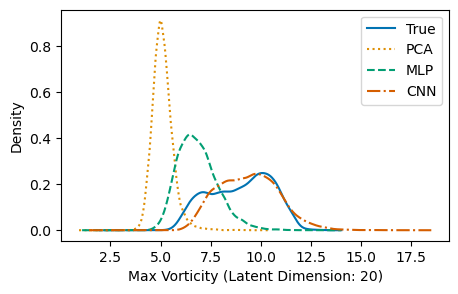

In [50]:
# Compute maximum vorticity for each model and the true data
max_w_true = np.max(np.abs(w), axis=(1,2))
max_w_pca = np.max(np.abs(w_pca), axis=(1,2))
max_w_mlp = np.max(np.abs(w_mlp), axis=(1,2))
max_w_cnn = np.max(np.abs(w_cnn), axis=(1,2))

# Colorblind-friendly palette
colors = sns.color_palette("colorblind", 4)
line_styles = ['-', ':', '--', '-.']

plt.figure(figsize=(5, 3))
for i, (max_w, label) in enumerate([
    (max_w_true, 'True'),
    (max_w_pca, 'PCA'),
    (max_w_mlp, 'MLP'),
    (max_w_cnn, 'CNN')
]):
    kde_x, kde_y = custom_KDE(max_w).evaluate()
    plt.plot(kde_x, kde_y, label=label, color=colors[i], linestyle=line_styles[i])

plt.xlabel(f'Max Vorticity (Latent Dimension: {latent_dim})')
plt.ylabel('Density')
plt.legend(frameon=True)
# plt.title('KDE of Maximum Vorticity')
plt.savefig(f'{project_root}/figures/{project}/rom/kde_max_vorticity_latent_dim_{latent_dim}.png',
            bbox_inches='tight', dpi=300)
plt.show()


In [13]:
# Helper function to compute RMSE for a given set of indices
def compute_rmse(true, pred, idx):
    return np.sqrt(np.mean((true[idx] - pred[idx]) ** 2))

sets = {
    'Train': train_idx,
    'Val': val_idx,
    'Test': test_idx
}

# Max vorticity RMSE
for set_name, idx in sets.items():
    rmse_pca = compute_rmse(max_w_true, max_w_pca, idx)
    rmse_mlp = compute_rmse(max_w_true, max_w_mlp, idx)
    rmse_cnn = compute_rmse(max_w_true, max_w_cnn, idx)
    print(f"{set_name} max vorticity RMSE: PCA={rmse_pca:.6f}, MLP={rmse_mlp:.6f}, CNN={rmse_cnn:.6f}")

# u1, u2, omega RMSE
for set_name, idx in sets.items():
    u1_true_set = data[idx, 0]
    u2_true_set = data[idx, 1]
    w_true_set = w[idx]

    u1_pca_set = u1_pca[idx]
    u2_pca_set = u2_pca[idx]
    w_pca_set = w_pca[idx]

    u1_mlp_set = u1_mlp[idx]
    u2_mlp_set = u2_mlp[idx]
    w_mlp_set = w_mlp[idx]

    u1_cnn_set = u1_cnn[idx]
    u2_cnn_set = u2_cnn[idx]
    w_cnn_set = w_cnn[idx]

    rmse_u1_pca = compute_rmse(u1_true_set, u1_pca_set, np.arange(len(idx)))
    rmse_u2_pca = compute_rmse(u2_true_set, u2_pca_set, np.arange(len(idx)))
    rmse_w_pca = compute_rmse(w_true_set, w_pca_set, np.arange(len(idx)))

    rmse_u1_mlp = compute_rmse(u1_true_set, u1_mlp_set, np.arange(len(idx)))
    rmse_u2_mlp = compute_rmse(u2_true_set, u2_mlp_set, np.arange(len(idx)))
    rmse_w_mlp = compute_rmse(w_true_set, w_mlp_set, np.arange(len(idx)))

    rmse_u1_cnn = compute_rmse(u1_true_set, u1_cnn_set, np.arange(len(idx)))
    rmse_u2_cnn = compute_rmse(u2_true_set, u2_cnn_set, np.arange(len(idx)))
    rmse_w_cnn = compute_rmse(w_true_set, w_cnn_set, np.arange(len(idx)))

    print(f"{set_name} RMSE:")
    print(f"  PCA: u1={rmse_u1_pca:.6f}, u2={rmse_u2_pca:.6f}, omega={rmse_w_pca:.6f}")
    print(f"  MLP: u1={rmse_u1_mlp:.6f}, u2={rmse_u2_mlp:.6f}, omega={rmse_w_mlp:.6f}")
    print(f"  CNN: u1={rmse_u1_cnn:.6f}, u2={rmse_u2_cnn:.6f}, omega={rmse_w_cnn:.6f}")


Train max vorticity RMSE: PCA=4.123163, MLP=2.409350, CNN=0.859382
Val max vorticity RMSE: PCA=4.116898, MLP=2.494780, CNN=0.955176
Test max vorticity RMSE: PCA=4.123722, MLP=2.519654, CNN=0.958858
Train RMSE:
  PCA: u1=0.201541, u2=0.241505, omega=1.274006
  MLP: u1=0.138064, u2=0.163925, omega=0.885379
  CNN: u1=0.068861, u2=0.074328, omega=0.543405
Val RMSE:
  PCA: u1=0.203038, u2=0.243128, omega=1.279204
  MLP: u1=0.158840, u2=0.184138, omega=0.973069
  CNN: u1=0.109348, u2=0.113659, omega=0.693233
Test RMSE:
  PCA: u1=0.206741, u2=0.247349, omega=1.293613
  MLP: u1=0.164045, u2=0.187539, omega=0.992332
  CNN: u1=0.113523, u2=0.117409, omega=0.714255


In [23]:
# Compute per-sample RMSE for CNN vorticity on test set
rmse_per_sample = np.sqrt(np.mean((w[test_idx] - w_cnn[test_idx])**2, axis=(1,2)))
avg_rmse = np.mean(rmse_per_sample)

# Find the 20 test indices closest to the average RMSE, pick the 15th for visualization
closest_indices = np.argsort(np.abs(rmse_per_sample - avg_rmse))[:20]
idx = test_idx[closest_indices[0]]

print("Closest test indices:", test_idx[closest_indices])
print("Corresponding RMSEs:", rmse_per_sample[closest_indices])

Closest test indices: [19680  9407 16350 18515  7926 13097  8874  8638  5560 11350  3431  5710
 12374  3738 14449 14666  8872  7928 17219 19986]
Corresponding RMSEs: [0.62118187 0.6210049  0.62099713 0.62123817 0.62094048 0.62126769
 0.62086596 0.6213652  0.620814   0.62072833 0.62148509 0.62149346
 0.62149375 0.62063085 0.62157499 0.62157577 0.62157643 0.62158815
 0.62057606 0.62057008]


In [30]:
idx = 9407

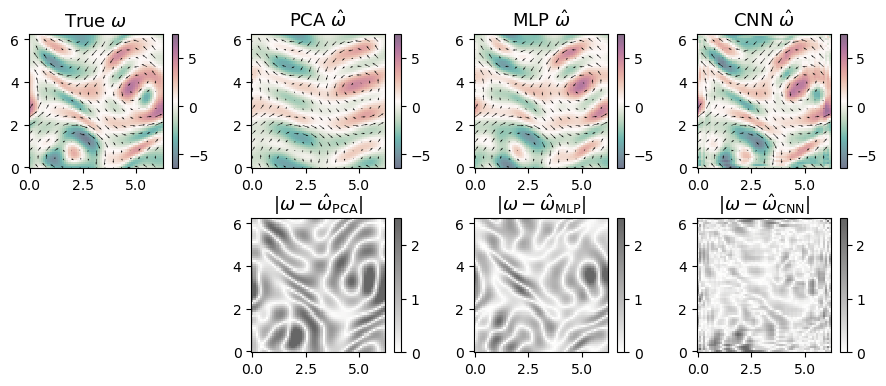

In [ ]:
fs = 13
fig, axes = plt.subplots(2, 4, figsize=(9, 3.75))

def plot_vorticity(ax, field, title, vmin, vmax, quiver=None, alpha=0.6, cmap=cm.cm.curl):
    mesh = ax.pcolormesh(grid_x, grid_y, field, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto', alpha=alpha)
    ax.set_title(title, fontsize=fs)
    ax.set_aspect('equal')
    fig.colorbar(mesh, ax=ax)
    if quiver is not None:
        ax.quiver(grid_x[::4, ::4], grid_y[::4, ::4], quiver[0][::4, ::4], quiver[1][::4, ::4], color='black')

vmin_w = np.min([w[idx], w_pca[idx], w_mlp[idx], w_cnn[idx]])
vmax_w = np.max([w[idx], w_pca[idx], w_mlp[idx], w_cnn[idx]])

plot_vorticity(axes[0, 0], w[idx], 'True $\omega$', vmin_w, vmax_w, quiver=(u1[idx], u2[idx]))
plot_vorticity(axes[0, 1], w_pca[idx], 'PCA $\hat{\omega}$', vmin_w, vmax_w, quiver=(u1_pca[idx], u2_pca[idx]))
plot_vorticity(axes[0, 2], w_mlp[idx], 'MLP $\hat{\omega}$', vmin_w, vmax_w, quiver=(u1_mlp[idx], u2_mlp[idx]))
plot_vorticity(axes[0, 3], w_cnn[idx], 'CNN $\hat{\omega}$', vmin_w, vmax_w, quiver=(u1_cnn[idx], u2_cnn[idx]))

# Second row: error fields (true - predicted)
error_pca = np.abs(w[idx] - w_pca[idx])
error_mlp = np.abs(w[idx] - w_mlp[idx])
error_cnn = np.abs(w[idx] - w_cnn[idx])

vmin_err = 0
vmax_err = 2.5

plot_vorticity(axes[1, 1], error_pca, '$|\omega - \hat{\omega}_\mathrm{PCA}$|', vmin_err, vmax_err, cmap=cm.cm.gray_r)
plot_vorticity(axes[1, 2], error_mlp, '$|\omega - \hat{\omega}_\mathrm{MLP}$|', vmin_err, vmax_err, cmap=cm.cm.gray_r)
plot_vorticity(axes[1, 3], error_cnn, '$|\omega - \hat{\omega}_\mathrm{CNN}$|', vmin_err, vmax_err, cmap=cm.cm.gray_r)

axes[1, 0].axis('off')

plt.tight_layout(pad=0.65)
plt.savefig(f'{project_root}/figures/{project}/rom/vorticity_comparison_latent_dim_{latent_dim}_idx_{idx}.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
def pattern_corr(a, b):
    # Flatten spatial dimensions, compute centered pattern correlation
    a_flat = a.reshape(a.shape[0], -1)
    b_flat = b.reshape(b.shape[0], -1)
    # Remove mean over spatial dimensions
    a_centered = a_flat - a_flat.mean(axis=1, keepdims=True)
    b_centered = b_flat - b_flat.mean(axis=1, keepdims=True)
    # Compute correlation for each sample
    num = np.sum(a_centered * b_centered, axis=1)
    denom = np.sqrt(np.sum(a_centered**2, axis=1) * np.sum(b_centered**2, axis=1))
    return num / denom

# Example usage:
corr_pca = pattern_corr(w_true_set, w_pca_set)
corr_mlp = pattern_corr(w_true_set, w_mlp_set)
corr_cnn = pattern_corr(w_true_set, w_cnn_set)

print("Pattern correlation (PCA):", np.mean(corr_pca))
print("Pattern correlation (MLP):", np.mean(corr_mlp))
print("Pattern correlation (CNN):", np.mean(corr_cnn))


Pattern correlation (PCA): 0.8127427339036778
Pattern correlation (MLP): 0.8994878300707673
Pattern correlation (CNN): 0.9550993844689301


Closest test indices: [19680  9407 16350 18515  7926 13097  8874  8638  5560 11350  3431  5710
 12374  3738 14449 14666  8872  7928 17219 19986]
Corresponding RMSEs: [0.62118187 0.6210049  0.62099713 0.62123817 0.62094048 0.62126769
 0.62086596 0.6213652  0.620814   0.62072833 0.62148509 0.62149346
 0.62149375 0.62063085 0.62157499 0.62157577 0.62157643 0.62158815
 0.62057606 0.62057008]


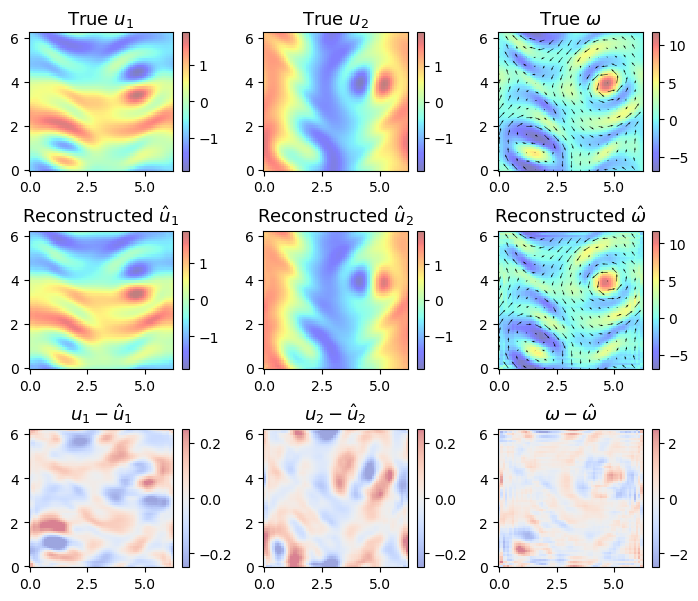

In [ ]:
# # Compute per-sample RMSE for CNN vorticity on test set
# rmse_per_sample = np.sqrt(np.mean((w[test_idx] - w_cnn[test_idx])**2, axis=(1,2)))
# avg_rmse = np.mean(rmse_per_sample)

# # Find the 20 test indices closest to the average RMSE, pick the 15th for visualization
# closest_indices = np.argsort(np.abs(rmse_per_sample - avg_rmse))[:20]
# idx = test_idx[closest_indices[14]]

# print("Closest test indices:", test_idx[closest_indices])
# print("Corresponding RMSEs:", rmse_per_sample[closest_indices])

# fs = 13
# fig, axes = plt.subplots(3, 3, figsize=(7, 6))

# # Helper for plotting fields
# def plot_data(ax, field, title, cmap, vmin=None, vmax=None, alpha=0.5, colorbar=True, quiver=None):
#     mesh = ax.pcolormesh(grid_x, grid_y, field, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
#     ax.set_title(title, fontsize=fs)
#     if colorbar:
#         fig.colorbar(mesh, ax=ax)
#     if quiver is not None:
#         ax.quiver(grid_x[::4, ::4], grid_y[::4, ::4], quiver[0][::4, ::4], quiver[1][::4, ::4], color='black')

# # True fields
# plot_data(axes[0, 0], u1[idx], 'True $u_1$', 'jet', vmin=np.min(u1[idx]), vmax=np.max(u1[idx]))
# plot_data(axes[0, 1], u2[idx], 'True $u_2$', 'jet', vmin=np.min(u2[idx]), vmax=np.max(u2[idx]))
# plot_data(axes[0, 2], w[idx], 'True $\omega$', 'jet', vmin=np.min(w[idx]), vmax=np.max(w[idx]), quiver=(u1[idx], u2[idx]))

# # CNN reconstructed fields
# plot_data(axes[1, 0], u1_cnn[idx], 'Reconstructed $\hat{u}_1$', 'jet', vmin=np.min(u1[idx]), vmax=np.max(u1[idx]))
# plot_data(axes[1, 1], u2_cnn[idx], 'Reconstructed $\hat{u}_2$', 'jet', vmin=np.min(u2[idx]), vmax=np.max(u2[idx]))
# plot_data(axes[1, 2], w_cnn[idx], 'Reconstructed $\hat{\omega}$', 'jet', vmin=np.min(w[idx]), vmax=np.max(w[idx]), quiver=(u1_cnn[idx], u2_cnn[idx]))

# # Differences
# diff_u1 = u1[idx] - u1_cnn[idx]
# diff_u2 = u2[idx] - u2_cnn[idx]
# diff_w = w[idx] - w_cnn[idx]
# vmin_u = np.min([diff_u1, diff_u2])
# vmax_u = np.max([diff_u1, diff_u2])

# vmin_u, vmax_u = -0.25, 0.25

# plot_data(axes[2, 0], diff_u1, '$u_1 - \hat{u}_1$', 'coolwarm', vmin=vmin_u, vmax=vmax_u)
# plot_data(axes[2, 1], diff_u2, '$u_2 - \hat{u}_2$', 'coolwarm', vmin=vmin_u, vmax=vmax_u)
# plot_data(axes[2, 2], diff_w, '$\omega - \hat{\omega}$', 'coolwarm', vmin=-2.5, vmax=2.5)

# plt.tight_layout(pad=0.65)
# plt.savefig(f'{project_root}/figures/{project}/rom/CNN_autoencoder_error_latent_dim_{latent_dim}_idx_{idx}.png', dpi=300, bbox_inches='tight')
# plt.show()
